# Called Third Strike
## Part 3. First crude neural network  

![](./resources/baseball_umpire_home_plate_1.jpg)

This project's goal is to build probability models for as to whether a pitch will be called a strike or not. The intended models are to be:
1. A neural network (NN) based approach.
2. A non-NN based approach.

---

__**This Notebook's**__ objective is to quickly build a simple working neural network to give a baseline to compare against as we iterate versions. 

---
---

### Table of Contents<a id='toc2'></a>

<a href='#dat_prep'>1. Data Preprocessing</a>

<a href='#build_model'>2. Build Model</a>

<a href='#rand_search'>3. Random Hyperparameter Search</a>

<a href='#summary'>4. Summary</a>

...

<a href='#end'>Go to the End</a>

---

---  

<span style="font-size:0.5em;">Tag 1</span>

### Data Preprocessing
<a id='dat_prep'></a>

<span style="font-size:0.5em;"><a href='#toc2'>Back to TOC</a></span>

#### Libraries


In [77]:
# Data wrangling and operations
import pandas as pd
import numpy as np
from datetime import datetime
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, auc
from sklearn.metrics import roc_curve, RocCurveDisplay

# neural networks
# Kera Sequential model
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

Import the following packages, if needed (not included in default packages on the platform I'm currently using)

In [2]:
%%capture
try:
    import scikeras
except ImportError:
    !pip install scikeras[tensorflow]
    !python -m pip install scikeras[tensorflow]
except ModuleNotFoundError:
    !pip install scikeras[tensorflow]
    # !python -m pip install scikeras[tensorflow]

In [3]:
from scikeras.wrappers import KerasClassifier

In [4]:
# Dependency for plot_model function

In [5]:
%%capture
try:
    import pydot
except ImportError:
    !pip install pydot

---

#### Data Import 

Retrieve the latest version of our train/test files that we built during [initial exploration](02_data_exploration.ipynb).

In [6]:
df_train = pd.read_pickle('../data/train_enriched.pkl')
df_test = pd.read_pickle('../data/test_enriched.pkl')

Let's refamiliarize ourselves with the features.

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350959 entries, 0 to 354038
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   pitch_id              350959 non-null  object        
 1   inning                350959 non-null  int64         
 2   side                  350959 non-null  object        
 3   run_diff              350959 non-null  int64         
 4   at_bat_index          350959 non-null  int64         
 5   pitch_of_ab           350959 non-null  int64         
 6   batter                350959 non-null  int64         
 7   pitcher               350959 non-null  int64         
 8   catcher               350959 non-null  int64         
 9   umpire                350959 non-null  int64         
 10  bside                 350959 non-null  object        
 11  pside                 350959 non-null  object        
 12  stringer_zone_bottom  350959 non-null  float64       
 13 

---

#### Feature Selection and Prep

Select features:

For our initial super simple model, let's just pick four features: 
- `px` which is the horizontal location of the pitch at the plate
- `pz` which is the vertical location
- `stringer_zone_bottom` which is an estimate of current batter's strike zone bottom
- `stringer_zone_top` which is an estimate of current batter's strike zone top

In [8]:
# Features selected
feat_select = ['px', 'pz', 'stringer_zone_bottom', 'stringer_zone_top']

Prep features:

In [9]:
# Get just the selected features
df_X = df_train[feat_select]
display(df_X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350959 entries, 0 to 354038
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   px                    350959 non-null  float64
 1   pz                    350959 non-null  float64
 2   stringer_zone_bottom  350959 non-null  float64
 3   stringer_zone_top     350959 non-null  float64
dtypes: float64(4)
memory usage: 13.4 MB


None

While we are at it, let's prep our targets:

In [10]:
df_y = df_train['strike_bool']
display(pd.DataFrame(df_y).info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350959 entries, 0 to 354038
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   strike_bool  350959 non-null  int64
dtypes: int64(1)
memory usage: 5.4 MB


None

---

#### Feature Engineering

Select features:

For a neural network we will need to numerically represent our data (e.g. one-hot-encode any categorical features), as well as scale/normalize the data. 

All the selected features for this round are numerical, so we don't have to worry about encoding any categories. For scaling I'm choosing to *standardize*.

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_X)

---

#### Train / Test


Create train/test splits.

Breakout parameters for easy access.

In [12]:
# Parameters
test_size = 0.20
random_state = 24

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df_y, test_size=test_size
                                                    ,stratify=df_y,random_state = 24)

---  

<span style="font-size:0.5em;">Tag 2</span>

### Build Model<a id='build_model'></a>

<span style="font-size:0.5em;"><a href='#toc2'>Back to TOC</a></span>

---

#### First Neural Network Model

Let's set up our initial parameters and build our models.

We will use the Kera Sequential model.

In [14]:
# Initial Parameters
num_inputs = X_train.shape[1]
num_units_dense_1 = 2
num_outputs = 1
activ_dense = 'sigmoid'
activ_output = 'sigmoid'

n_epochs = 2
val_split = 0.10

Model: "seq_model_strike"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_1 (Dense)            (None, 2)                 10        
                                                                 
 Output (Dense)              (None, 1)                 3         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


2022-05-07 03:12:52.375399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-07 03:12:52.375432: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-07 03:12:52.375453: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (18ab3b83-6ff3-46f7-8fe7-ca1b4f9817ab): /proc/driver/nvidia/version does not exist
2022-05-07 03:12:52.375682: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


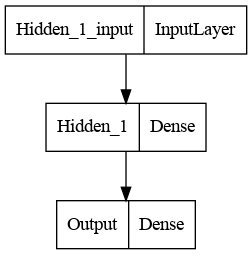

In [15]:
# Create a Sequential model
model = Sequential(name='seq_model_strike')

# Add an input layer and a hidden layer with 10 neurons
model.add(Dense(num_units_dense_1, input_shape=(num_inputs,)
                ,activation=activ_dense, name='Hidden_1'))

# Add a 1-neuron output layer
model.add(Dense(num_outputs, activation=activ_output, name='Output'))

# Compile your model
model.compile(loss='binary_crossentropy', optimizer='adam'
              ,metrics=['accuracy']
             )

# Summarise your model
model.summary()

plot_model(model)

In [16]:
f"To keep it realtively simple, we chose to use {num_units_dense_1} nodes in 1 hidden layer."

'To keep it realtively simple, we chose to use 2 nodes in 1 hidden layer.'

---

#### Model training

We will save the model `History`.

In [17]:
# Train model
mod_hist =  model.fit(X_train, y_train, epochs = n_epochs
                        ,validation_split=val_split)

Epoch 1/2
7897/7897 [==============================] - 8s 989us/step - loss: 0.5827 - accuracy: 0.6859 - val_loss: 0.4972 - val_accuracy: 0.7253
Epoch 2/2
7897/7897 [==============================] - 8s 972us/step - loss: 0.4570 - accuracy: 0.7576 - val_loss: 0.4378 - val_accuracy: 0.7684


Not too bad through 2 epochs. Kind of weird that train accuracy is lower than validation accuracy, but we won't worry too much about it right now; only if we keep seeing it consistently in subsequent runs/tuning.

Let's convert the history to a `DataFrame` for easier manipulation.

In [18]:
df_mod_history = (pd.DataFrame(mod_hist.history).reset_index()
                  .rename(columns={'index': 'epoch', 'loss': 'train_loss'
                                   ,'accuracy': 'train_accuracy'}) 
                 )

In [19]:
df_mod_history

,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,0,0.582684,0.685860,0.497234,0.725291
1,1,0.457019,0.757616,0.437846,0.768423


Let's do a quick viz on the accuracy over the two epochs.

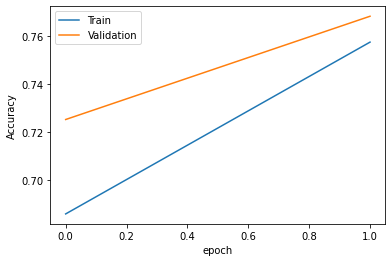

In [20]:
_ = sns.lineplot(data=df_mod_history, x='epoch', y='train_accuracy')
_ = sns.lineplot(data=df_mod_history, x='epoch', y='val_accuracy')
# _.set(ylim=(min_y,1))
_.set_ylabel("Accuracy")
plt.legend(labels=["Train","Validation"])
plt.show()

Let's evaluate the model on the *test* set.

In [21]:
# Evaluate model accuracy on the test set
accuracy = model.evaluate(X_test, y_test)[1]

# Print accuracy
print('Accuracy:', accuracy)

2194/2194 [==============================] - 2s 719us/step - loss: 0.4386 - accuracy: 0.7688
Accuracy: 0.768777072429657


Test accuracy of .77 is in line with what we saw out of train/val (.76/0.77).

Now that we created a single model as a warmup, let's try to hone in on a good candidate using Random Hyperparameter Search.

---  

<span style="font-size:0.5em;">Tag 3</span>

### Random Hyperparameter Search<a id='rand_search'></a>

<span style="font-size:0.5em;"><a href='#toc2'>Back to TOC</a></span>

#### Preparation

Let's create functions for:
- Model build

In reviewing methodology to use `keras` with `sklearn`, I found `scikeras`. Their [tutorial](https://www.adriangb.com/scikeras/stable/notebooks/Basic_Usage.html#4.2-Saving-using-Keras-saving-methods) has a lot of good examples on how to leverage `sklearn` functionality but use Keras models, so alot of the following will be leveraging those example codes.

Create model build function to create a binary classification neural network model that ingests the current set of parameters.

In [22]:
# Full credit to scikeras tutorial (see 2.2 in 'tutorial' link above)
def get_clf(meta, hidden_layer_sizes, dropout):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation="relu"))
        model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    return model

Instantiate a `scikeras` classifier:

In [23]:
clf = KerasClassifier(
    model=get_clf,
    loss="binary_crossentropy",
    optimizer="adam",
    optimizer__lr=0.1,
    model__hidden_layer_sizes=(100,),
    model__dropout=0.5,
    verbose=True,
    metrics=['binary_accuracy'],
    validation_split=0.10
)

# clf.fit(X_train, y_train)

Let's create a grid of parameters and do a random search to identify the most promising combination.


Create `dict` of parameters to perform random search on.

In [24]:
params = {
    'optimizer__lr': [0.001, 0.01, 0.05, 0.5],
    'model__hidden_layer_sizes': [(100,), (50, 50, )],
    'model__dropout': [0, 0.5],
    'epochs': [2, 3, 5],
    'batch_size': [32, 128, 256]
}

Instantiate the `RandomSearchCV` object:

In [25]:
rs = RandomizedSearchCV(estimator=clf
                        ,param_distributions=params
                        ,cv=5
                        ,refit=True
                        ,verbose=True
                        )

Fit to the training data!

In [26]:
rs_results = rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/5
1580/1580 [==============================] - 2s 1ms/step - loss: 0.1860 - binary_accuracy: 0.9184 - val_loss: 0.1802 - val_binary_accuracy: 0.9212
Epoch 2/5
1580/1580 [==============================] - 2s 1ms/step - loss: 0.1764 - binary_accuracy: 0.9231 - val_loss: 0.1790 - val_binary_accuracy: 0.9208
Epoch 3/5
1580/1580 [==============================] - 2s 1ms/step - loss: 0.1737 - binary_accuracy: 0.9240 - val_loss: 0.1752 - val_binary_accuracy: 0.9240
Epoch 4/5
1580/1580 [==============================] - 2s 1ms/step - loss: 0.1725 - binary_accuracy: 0.9250 - val_loss: 0.1740 - val_binary_accuracy: 0.9248
Epoch 5/5
439/439 [==============================] - 0s 586us/step
Epoch 1/5
1580/1580 [==============================] - 2s 1ms/step - loss: 0.1859 - binary_accuracy: 0.9181 - val_loss: 0.2032 - val_binary_accuracy: 0.9135
Epoch 2/5
1580/1580 [==============================] - 2s 1ms/step - loss: 0.1750 - bin

Let's look at the best accuracy score, and the parameters that produced them.

In [27]:
display(rs_results.best_score_, rs_results.best_params_)

0.9281218929871564

{'optimizer__lr': 0.001,
 'model__hidden_layer_sizes': (100,),
 'model__dropout': 0,
 'epochs': 5,
 'batch_size': 256}

Let's look at it as an estimator object.

In [28]:
rs_best = rs_results.best_estimator_
display(rs_best)

KerasClassifier(
	model=<function get_clf at 0x7f623edc3310>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=['binary_accuracy']
	batch_size=256
	validation_batch_size=None
	verbose=True
	callbacks=None
	validation_split=0.1
	shuffle=True
	run_eagerly=False
	epochs=5
	optimizer__lr=0.001
	model__hidden_layer_sizes=(100,)
	model__dropout=0
	class_weight=None
)

Let's look at a high level plot of the model, to make sure it makes sense vis a vis the best params.

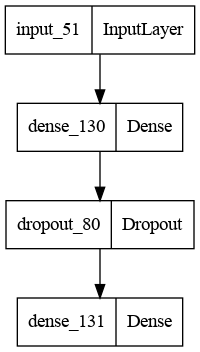

In [29]:
plot_model(rs_best.model_)

Look at summary:

In [30]:
rs_best.model_.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_130 (Dense)           (None, 100)               500       
                                                                 
 dropout_80 (Dropout)        (None, 100)               0         
                                                                 
 dense_131 (Dense)           (None, 1)                 101       
                                                                 
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________


Ok, let's `pickle` the results for later reference if we can't complete our review right away.

In [34]:
str_ts = datetime.now().strftime("%Y%m%d_%H%M")
file_nm = 'nn_rs_1st_pass_' + str_ts
file_path = './models/rs_results/' + file_nm + '.pickle'
# pred_path = './predictions/test/' + file_nm + '.csv'

display(file_path)

with open(file_path, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(rs_results, f, pickle.HIGHEST_PROTOCOL)

'./models/rs_results/nn_rs_1st_pass_20220507_0327.pickle'

2022-05-07 03:27:48.018103: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram:///tmp/tmp17q1zrs2/assets


In [35]:
%%script echo skipping
# Test loading pickle
load_path = './models/rs_results/classic_rs_1st_pass_20220505_1544.pickle'

with open(load_path, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    rs_rez_unpkl = pickle.load(f)

skipping


Now let's look at performance vs Test.

In [36]:
display(f"test accuracy: {rs_best.score(X_test, y_test)}")
display(f"train accuracy: {rs_results.best_score_}")

275/275 [==============================] - 0s 600us/step


'test accuracy: 0.9277695463870527'

'train accuracy: 0.9281218929871564'

Consistent, and aligns.

Let's get some predictions and review some high level classification metrics:

In [37]:
rs_pred = rs_best.predict(X_test)

275/275 [==============================] - 0s 714us/step


*Confusion Matrix*

In [38]:
cm = confusion_matrix(y_test, rs_pred)
display(cm)

array([[45765,  2447],
       [ 2623, 19357]])

*Accuracy*

In [39]:
display("What % of pitches did we correctly categorize?")
display(f"test accuracy: {round(rs_best.score(X_test, y_test), 3)}")

'What % of pitches did we correctly categorize?'

275/275 [==============================] - 0s 599us/step


'test accuracy: 0.928'

*Precision*

In [40]:
precision = precision_score(y_test, rs_pred)
display("What % predicted strikes did we get correct?")
display(f"Positive Predictive Value: {round(precision,3)}")

'What % predicted strikes did we get correct?'

'Positive Predictive Value: 0.888'

*Recall*

In [41]:
recall = recall_score(y_test, rs_pred)
display("What percent of actual strikes did we get capture?")
display(f"True Positive Rate: {round(recall, 3)}")

'What percent of actual strikes did we get capture?'

'True Positive Rate: 0.881'

These are pretty good results so far. I had no preconceptions on what we could achieve based on first ok model, so >0.90 is very exciting.

*ROC/AUC*

275/275 [==============================] - 0s 622us/step


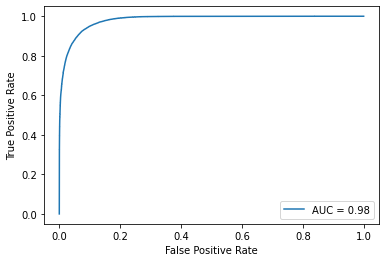

In [89]:
fpr, tpr, thresholds = roc_curve(y_test, rs_best.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()
plt.show()

In [90]:
%%html
<style>
table {float:left}
</style>

AUC of 0.98! This is really good, considering rough rule of thumb is >0.85 is a good performing classifier.

*Save the current state*

Let's save out the best model!

In [ ]:
str_ts = datetime.now().strftime("%Y%m%d_%H%M")
model_nm = 'nn_1st_pass_' + str_ts
model_path = './models/' + model_nm
pred_path = './predictions/test/' + model_nm + '.csv'

display(model_path, pred_path)

# save out predicted probabilities
pred_curr = rs_best.predict_proba(X_test)
np.savetxt(pred_path, pred_curr, delimiter=",")

# Save out Keras model
rs_best.model_.save(model_path)

---  
<span style="font-size:0.5em;">Tag 4</span>

### Summary <a id='summary'></a>

<span style="font-size:0.5em;"><a href='#toc2'>Back to TOC</a></span>

<span style="color:blue">
    
Our metric of choice is Accuracy, and the best model found by the random search over **10** iterations had a:

- training accuracy of **0.928**
- test accuracy was **0.928** as well

Other classification metrics for context are:
- Precision/Positive Predictive Value: **0.888**
- Recall/True Positive Rate: **0.881**
- ROC AUC: **0.98**

All these metrics I would consider to be very good performance, contigent on specific use case of ultimate customer(s). For example a requirement might that the customer might want to maximize PPV as much as possible and would like to target >0.90.
</span>

In [88]:
%%html
<style>
table {float:left}
</style>

---  
<span style="font-size:0.5em;">End of current work</span>

<a id='end'></a>

<span style="font-size:0.5em;"><a href='#toc2'>Back to TOC</a></span>

-----

### Archive

Here is the model creation function I started building, before I stumbled across `scikeras` and decided to run with their code.

In [ ]:
%%script echo skipping
def create_binary_nn_model(num_inputs, learning_rate=0.01, num_layers=1
                           ,num_nodes=2, activation='relu'):
    """Create binary neural network Sequential model"""
    # Create Adam optimizer
    opt = Adam(lr=learning_rate)
    
    # Create Sequential model
    model=Sequential()
    
    # Input layer
    model.add(Dense(num_nodes, input_shape=(num_inputs,) 
              ,activation=activation, name='Input'))
    
    # Additional Hidden Layers
    for i in range(num_layers-1): #if only 1 then assume just input/hidden
        model.add(Dense(num_nodes, activation=activation))
    
    # Add a 1-neuron output layer
    model.add(Dense(num_outputs, activation='sigmoid', name='Output'))

    # Compile your model
    model.compile(loss='binary_crossentropy', optimizer=opt
                  ,metrics=['accuracy']
                 )

    return model

Let's do a test on the function:

In [ ]:
%%script echo skipping
mod_1 = create_binary_nn_model(num_inputs=X_train.shape[1]
                               ,learning_rate=1
                               ,num_layers=1
                              )

In [ ]:
%%script echo skipping
hh = mod_1.fit(X_train, y_train, epochs = n_epochs
                        ,validation_split=val_split)

In [ ]:
%%script echo skipping
plot_model(mod_1)

Seems correct. I think that I plugged in a learning rate of 1 caused the epochs to be basically the same, basically skipping over minimums.